In [360]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [361]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import geopy.distance

import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/test.csv')
bus = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/bus_bts.csv')

In [362]:
# # k-means 로 묶기
# from sklearn.cluster import KMeans

# coord = train[['longitude', 'latitude']]

# iteration = []
# k_range = range(15, 25)

# for k in k_range:
#   kmeans = KMeans(n_clusters = k, random_state = 2020).fit(coord)
#   iteria = kmeans.inertia_ # 적정 군집 수 뽑기
#   print("K:", k, " cost:", iteria)
#   iteration.append(iteria)

# iteration = np.array(iteration) # 그냥 50으로 우선 해볼게,,,,,

In [363]:
# sns.scatterplot(x='longitude', y='latitude', size='18~20_ride', hue='coord_cluster', data=train)
# coord_cluster = kmeans.predict(coord_test)
# test['coord_cluster'] = coord_cluster

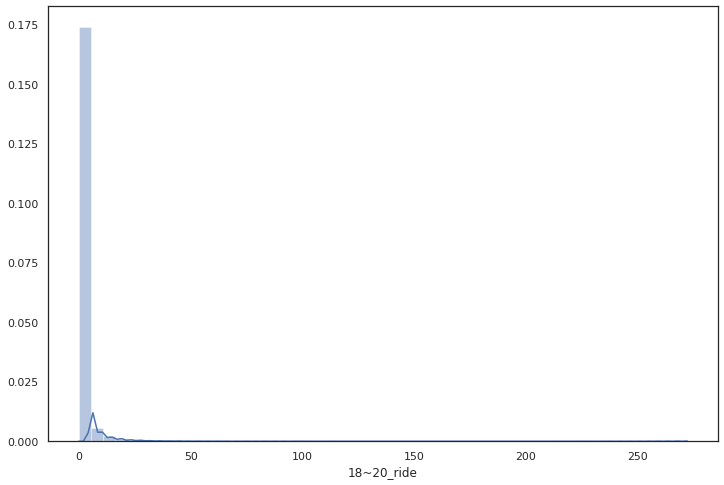

In [364]:
# 타겟 분포 확인
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(12,8))
sns.distplot(train['18~20_ride']) # 0 개많네,,, 이게맞냐? 

In [365]:
# station_name과 station_code가 1:1 매핑 X 
station = train.groupby('station_name')['station_code'].nunique().sort_values(ascending=False) # 정류장 이름과 코드가 일치되는지 확인
station

station_name
신안동         8
금악리         7
성읍1리        6
비석거리        6
조수1리        5
           ..
보목신협앞       1
보목신협        1
제주은행        1
제주자동차검사소    1
히귀반석        1
Name: station_code, Length: 1961, dtype: int64

하나의 정류장 이름에 code가 여러개 매핑되어있음.    
하나의 정류장 이름은 여러개의 코드, 위도 경도를 가짐.  
코드와 위도&경도는 고유함.    
> station code가 고윳값    

In [366]:
# 1. date 변수 변환
train['date'] = pd.to_datetime(train['date']) # datetime 변환
train['weekday'] = train['date'].dt.weekday # 요일 변환
# train = pd.get_dummies(train, columns=['weekday']) # 요일 getdummy로 펼치기

test['date'] = pd.to_datetime(test['date']) 
test['weekday'] = test['date'].dt.weekday 
# train = pd.get_dummies(train, columns=['weekday']) 
# test = pd.get_dummies(test, columns=['weekday'])

In [367]:
# 2. in_out 변수 변환(시내가 훨씬 많음)
train['in_out'] = train['in_out'].map({'시내':0, '시외':1})
test['in_out'] = test['in_out'].map({'시내':0, '시외':1})

In [368]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6


In [369]:
# 3. 승하차 시간대 통합
# 예측하려는 퇴근시간대가 2시간을 예측해야하므로, 2시간 단위로 통합해준다!
## 이런 인사이트를 가지려면 대체 어떻게해야하는거냐,,,,,,

train['68_ride']=train['6~7_ride']+train['7~8_ride'] 
train['810_ride']=train['8~9_ride']+train['9~10_ride']
train['1012_ride']=train['10~11_ride']+train['11~12_ride']

train['68_off']=train['6~7_takeoff']+train['7~8_takeoff'] 
train['810_off']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012_off']=train['10~11_takeoff']+train['11~12_takeoff']

test['68_ride']=test['6~7_ride']+test['7~8_ride'] 
test['810_ride']=test['8~9_ride']+test['9~10_ride']
test['1012_ride']=test['10~11_ride']+test['11~12_ride']

test['68_off']=test['6~7_takeoff']+test['7~8_takeoff'] 
test['810_off']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012_off']=test['10~11_takeoff']+test['11~12_takeoff']

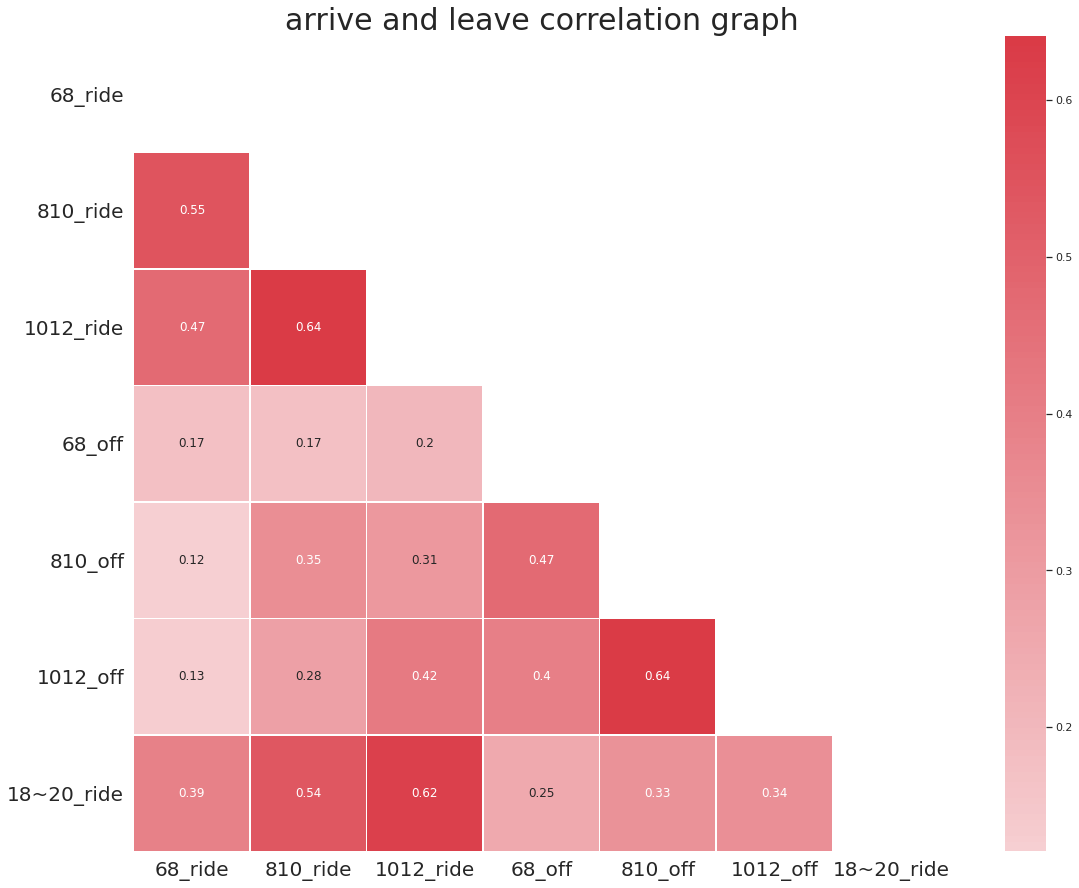

In [370]:
# heatmap 확인
train2 = train[['68_ride', '810_ride', '1012_ride', '68_off', '810_off', '1012_off', '18~20_ride']]
cor = train2.corr()
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

- **오전 10에서 12시 승차량**이 저녁 퇴근시간 6에서 8시 승차량에 가장 영향을 많이 준다!     
그 다음은 오전 8시~10시 승차량이다!  
- 오전 6시에서 8시 승차량은, 8시에서 10시 승차량과 상관계수가 높다.   
- 그리고 8시에서 10시 승차량도, 10시에서 12시 승차량과 상관계수가 높다. 
> **환승**의 영향일까? ㅎㅎ

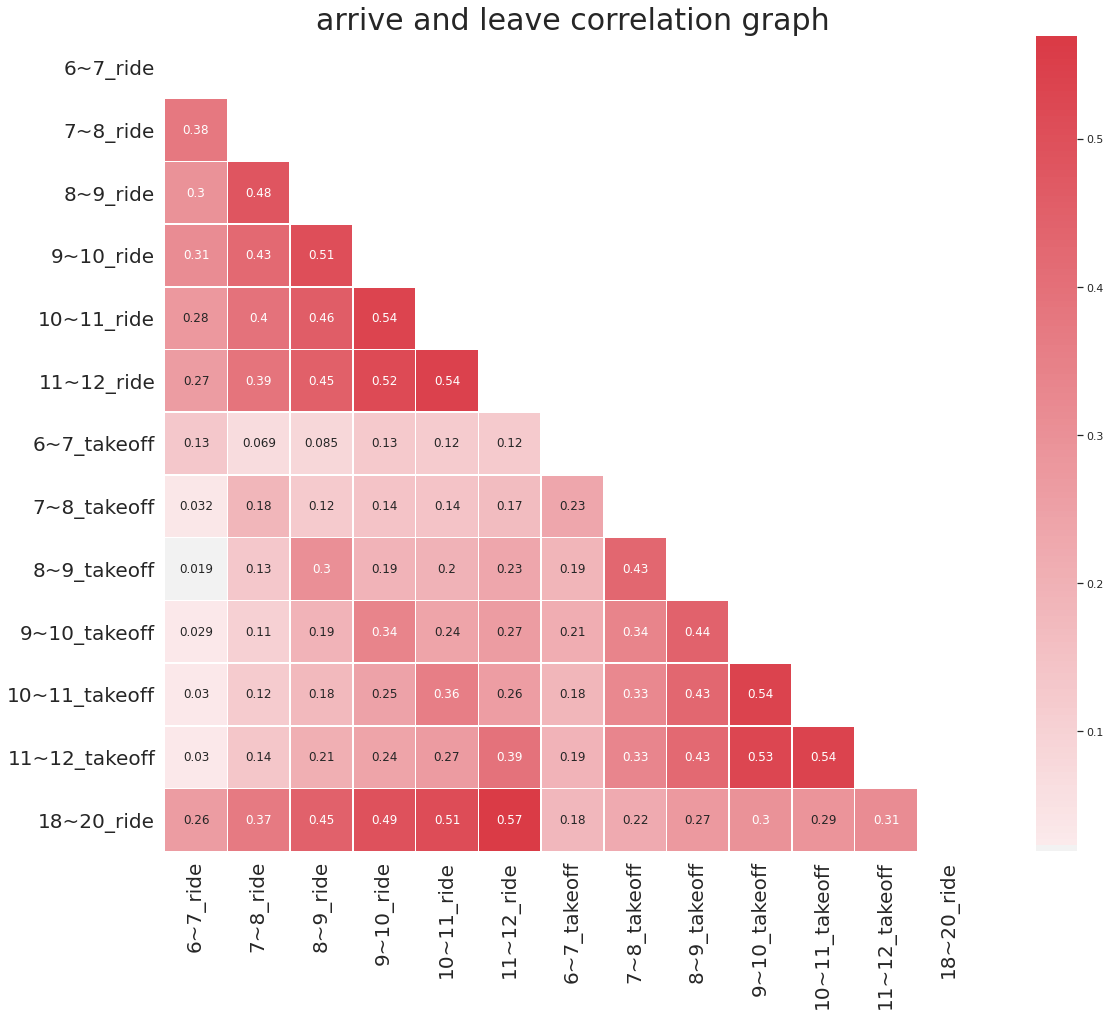

In [371]:
# 비통합 칼럼
train3 = train[['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', 
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride']]
cor = train3.corr()
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [372]:
# 4. 좌표 데이터를 이용한 Feature Engineering
# 제주도의 인구는 서귀포시와 제주시에 몰려있음. 
# 제주, 고산, 성산, 서귀포시의 측정소로 나누어 각각 피쳐로 추가!

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

# 정류소의 위치 확인 가능!

In [373]:
# 정류장의 위치 확인을 위한 groupby
data = train[['latitude', 'longitude', 'station_name']].drop_duplicates(keep='first')
data = data.groupby(['station_name'])['latitude', 'longitude'].mean()
# 정류장 이름이 같은 경우 평균 적용!

# 정류장 목록
data = data.reset_index()
data.head()

,station_name,latitude,longitude
0,(구)구판장,33.329705,126.797965
1,(구)중문동주민센터,33.251085,126.434300
2,(구)중앙파출소,33.247370,126.560713
3,(구)화산초등학교,33.326260,126.797250
4,1100고지휴게소,33.357820,126.463010


In [374]:
# 정류장 지도 표시
for row in data.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc)
map_osm

In [375]:
# 5. 측정소와 정류장사이 거리 계산(두 좌표간의 거리 계산 : geopy패키지)
# 정류장을 각 측정소와 인접한지 확인!
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [376]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name']) # Counter를 통해 확인
# 0 : 제주/ 1 : 고산/ 2 : 성산/ 3 : 포

Counter({0: 1479, 1: 659, 2: 597, 3: 828})

In [377]:
# dist_name 펼치기
# train = pd.get_dummies(train, columns=['dist_name'])

In [378]:
## 아니 이건 왜 이상하게 나오냐규
# total = pd.DataFrame( list(zip(t1, t2, t3, t3)), columns = ['jeju', 'gosan', 'seongsan', 'po'])
# train['dist_name'] = total.apply(lambda x:x.argmin(), axis=1) # 거리 최소 지점(argmin)을 dist_name으로 지정!
# data2 = train[['station_name', 'latitude', 'longitude', 'dist_name']].drop_duplicates(keep='first')
# data2.head()
# Counter(data2['dist_name'])

In [379]:
# test
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
# test = pd.get_dummies(test, columns=['dist_name'])

In [380]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0


In [381]:
# 5. 외부 기상데이터 사용
weather = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/weather.csv', encoding='cp949')

In [382]:
# 결측 개많네 당황스럽다;;
weather.columns

Index(['지점', '지점명', '일시', '기온(°C)', '기온 QC플래그', '강수량(mm)', '강수량 QC플래그',
       '풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그', '습도(%)', '습도 QC플래그',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)',
       '해면기압 QC플래그', '일조(hr)', '일조 QC플래그', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [383]:
weather.isnull().sum() # hmmmm.....

지점                  0
지점명                 0
일시                  0
기온(°C)              0
기온 QC플래그         4371
강수량(mm)          3441
강수량 QC플래그        3560
풍속(m/s)            46
풍속 QC플래그         4344
풍향(16방위)           58
풍향 QC플래그         4332
습도(%)               0
습도 QC플래그         4384
증기압(hPa)            0
이슬점온도(°C)           0
현지기압(hPa)           3
현지기압 QC플래그       4381
해면기압(hPa)           3
해면기압 QC플래그       4381
일조(hr)           2010
일조 QC플래그         2375
일사(MJ/m2)        3206
적설(cm)           4384
3시간신적설(cm)       4384
전운량(10분위)          18
중하층운량(10분위)        10
운형(운형약어)         2903
최저운고(100m )      1354
시정(10m)            15
지면상태(지면상태코드)     4384
현상번호(국내식)        3747
지면온도(°C)            2
지면온도 QC플래그       4382
5cm 지중온도(°C)     3288
10cm 지중온도(°C)    3288
20cm 지중온도(°C)    3288
30cm 지중온도(°C)    3288
dtype: int64

In [384]:
# 지점명 변경.. .이런 정보는 어디서아는거냐.....
weather['지점'] = weather['지점'].map(str)
weather['지점'] = weather['지점'].map({'184':'jeju', '185':'gosan', '188':'seongsan', '189':'po'})

# time 분류하기!! 문자열 인덱싱 중요해보임
weather['time'] = [ int(i.split(' ')[1].split(':')[0]) for i in weather['일시']]
weather['일시'] = [i.split(' ')[0] for i in weather['일시']]

# 12시 이전 시간대만 사용(data leakage 방지)
weather = weather.query('time<12')

# 지점, 일시에 따른 기온과 강수량 가져오기 + 바람(랜포에서는 오름)
weather2 = weather.groupby(['지점', '일시'])[['기온(°C)', '강수량(mm)',  '풍속(m/s)']].mean()
weather2 = weather2.reset_index().rename(columns={'일시':'date', '지점':'dist_name', '기온(°C)':'tem', '강수량(mm)':'rain', '풍속(m/s)':'wind'}).fillna(0.000000)

# to merge
weather2['dist_name'] = weather2['dist_name'].map({'gosan':1, 'seongsan':2, 'jeju':0, 'po':3})
weather2['date'] = pd.to_datetime(weather2['date'])

In [385]:
weather2.head()

,dist_name,date,tem,rain,wind
0,1,2019-09-01,23.363636,0.000000,2.309091
1,1,2019-09-02,23.008333,6.600000,3.875000
2,1,2019-09-03,23.800000,3.462500,3.600000
3,1,2019-09-04,24.216667,10.983333,4.383333
4,1,2019-09-05,25.583333,0.000000,4.533333


In [386]:
# 기존 데이터에 merge
train = pd.merge(train, weather2, how='left', on=['dist_name', 'date'])
test = pd.merge(test, weather2, how='left', on=['dist_name', 'date'])

In [387]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0,1.454545
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0,1.454545


In [388]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday', '68_ride', '810_ride', '1012_ride', '68_off',
       '810_off', '1012_off', 'dis_jeju', 'dis_gosan', 'dis_seongsan',
       'dis_po', 'dist_name', 'tem', 'rain', 'wind'],
      dtype='object')

In [389]:
test.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       'weekday', '68_ride', '810_ride', '1012_ride', '68_off', '810_off',
       '1012_off', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po',
       'dist_name', 'tem', 'rain', 'wind'],
      dtype='object')

In [390]:
print(train.shape, test.shape)

(415423, 36) (228170, 35)


## 위도 경도 집중

In [391]:
# 위도가 개중요하네(제주도랑 서귀포 집중...)
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0,1.454545
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0,1.454545
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0,24.109091,0.0,1.454545
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0,24.109091,0.0,1.454545
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,3,23.263636,0.0,1.245455


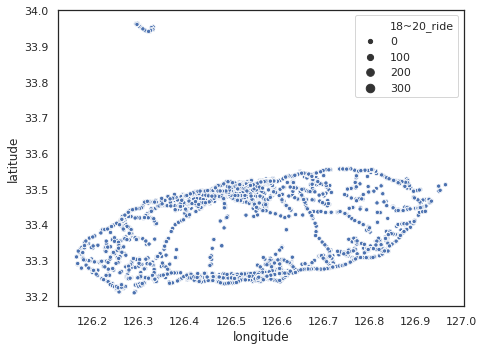

In [392]:
fig = plt.figure(figsize = (16, 12))

ax1 = plt.subplot(221)
sns.scatterplot(x='longitude', y='latitude', size='18~20_ride', data=train)

In [393]:
# 추자도 ㅋㅋ
train.query('latitude>33.9')

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind
81,81,2019-09-01,20010000,1,6115000,여객선대합실,33.96269,126.29761,0.0,2.0,1.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2.0,3.0,6.0,0.0,0.0,0.0,54.204373,75.234779,83.662149,83.266840,0,24.109091,0.0,1.454545
82,82,2019-09-01,20010000,1,6115001,추자면자치센터,33.96364,126.29681,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.0,1.0,0.0,0.0,0.0,54.330471,75.326394,83.790322,83.389537,0,24.109091,0.0,1.454545
83,83,2019-09-01,20010000,1,6115002,대서리사무소,33.96284,126.29564,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,5.0,0.0,0.0,0.0,0.0,54.292306,75.221025,83.792893,83.337438,0,24.109091,0.0,1.454545
84,84,2019-09-01,20010000,1,6115003,한의원,33.96232,126.29416,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.0,1.0,0.0,0.0,0.0,54.294446,75.141741,83.837927,83.323826,0,24.109091,0.0,1.454545
85,85,2019-09-01,20010000,1,6115004,엘지마트,33.96141,126.29452,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,2.0,0.0,0.0,0.0,0.0,54.188659,75.047581,83.739623,83.217550,0,24.109091,0.0,1.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399639,399639,2019-09-30,20010000,1,6115029,추자해변장여관,33.94379,126.32571,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,9.0,0.0,0.0,0.0,0.0,51.271352,73.659115,80.384838,80.510035,0,23.491667,0.0,0.950000
399640,399640,2019-09-30,20010000,1,6115032,신양2리,33.94093,126.32142,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,51.125497,73.267713,80.397719,80.316616,0,23.491667,0.0,0.950000
399641,399641,2019-09-30,20010000,1,6115035,묵리항,33.94468,126.31297,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,51.809278,73.522568,81.220833,80.939118,0,23.491667,0.0,0.950000
399642,399642,2019-09-30,20010000,1,6115036,묵리입구,33.94794,126.30906,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,4.0,0.0,0.0,0.0,0.0,52.283289,73.810043,81.730572,81.390500,0,23.491667,0.0,0.950000


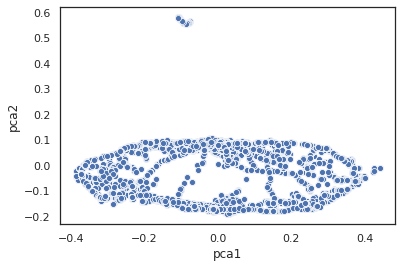

In [394]:
# PCA transformation으로 새로운 피쳐 만들기
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

coord = train[['latitude', 'longitude']] # 위도 경도 coord에 저장
pca = PCA(n_components=2)
pca.fit(coord)

coord_pca = pca.transform(coord)
coord_pca
train['pca1'] = coord_pca[:, 0]
train['pca2'] = coord_pca[:, 1]

sns.scatterplot(x='pca1', y='pca2', data=train)

In [395]:
# test 잊지말기!
coord_test = test[['latitude', 'longitude']] # 위도 경도 coord에 저장
pca = PCA(n_components=2)
pca.fit(coord_test)

coord_pca = pca.transform(coord_test)
coord_pca
test['pca1'] = coord_pca[:, 0]
test['pca2'] = coord_pca[:, 1]

In [396]:
print(train.shape, test.shape)

(415423, 38) (228170, 37)


In [397]:
# # k-means 로 묶기

# iteration = []
# k_range = range(4, 20)

# for k in k_range:
#   kmeans = KMeans(n_clusters = k, random_state = 2020).fit(coord)
#   iteria = kmeans.inertia_ # 적정 군집 수 뽑기
#   print("K:", k, " cost:", interia)
#   iteration.append(iteria)

# iteration = np.array(iteration)

# plt.plot(k_range, iteration)
# plt.vlines(5, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors='b')
# plt.title('적정 군집 수 찾기')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia')

In [398]:
# kmeans = KMeans(n_clusters=25, random_state = 2020).fit(coord)
# coord_cluster = kmeans.predict(coord)
# train['coord_cluster'] = coord_cluster

# coord_test = test[['latitude', 'longitude']]
# coord_cluster = kmeans.predict(coord_test)
# test['coord_cluster'] = coord_cluster

In [399]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind,pca1,pca2
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0,1.454545,-0.022880,0.076797
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0,1.454545,-0.031406,0.078329
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0,24.109091,0.0,1.454545,-0.044405,0.073546
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0,24.109091,0.0,1.454545,-0.020427,0.092523
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,3,23.263636,0.0,1.245455,-0.155421,-0.132541


# 커널 FE

In [400]:
# ## 관련 상관관계 높아 보이는 변수 묶기

# # 1. bus route + station code = route_station
# train['bus_route_id'] = train['bus_route_id'].astype(str)
# train['station_code'] = train['station_code'].astype(str)
# train['route_station'] = train['bus_route_id'] + ',' + train['station_code']

# test['bus_route_id'] = test['bus_route_id'].astype(str)
# test['station_code'] = test['station_code'].astype(str)
# test['route_station'] = test['bus_route_id'] + ',' + test['station_code']

# # 2. bus route + weekday
# train['bus_route_id_weekday'] = train['bus_route_id'].astype(str) + ',' + train['weekday'].astype(str) 
# test['bus_route_id_weekday'] = test['bus_route_id'].astype(str) + ',' + test['weekday'].astype(str) 

# # 3. station_code + weekday
# train['station_code_weekday'] = train['station_code'].astype(str) + ',' + train['weekday'].astype(str)
# test['station_code_weekday'] = test['station_code'].astype(str) + ',' + test['weekday'].astype(str)

# ## 4. route_station + weekday
# train['route_station_weekday'] = train['route_station'].astype(str) + ',' + train['weekday'].astype(str) 
# test['route_station_weekday'] = test['route_station'].astype(str) + ',' + test['weekday'].astype(str)

In [401]:
# # bus 데이터에서 시간대 추출
# bus['on_time']  = bus['geton_time'].apply(lambda x : x[:2])

# bus.iloc[bus.query('on_time == "06"').index,13] = '6~7_ride'
# bus.iloc[bus.query('on_time == "07"').index,13] = '7~8_ride'
# bus.iloc[bus.query('on_time == "08"').index,13] = '8~9_ride'
# bus.iloc[bus.query('on_time == "09"').index,13] = '9~10_ride'
# bus.iloc[bus.query('on_time == "10"').index,13] = '10~11_ride'
# bus.iloc[bus.query('on_time == "11"').index,13] = '11~12_ride'

# bus.shape

In [402]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind,pca1,pca2
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0,1.454545,-0.022880,0.076797
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0,1.454545,-0.031406,0.078329


In [403]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday', '68_ride', '810_ride', '1012_ride', '68_off',
       '810_off', '1012_off', 'dis_jeju', 'dis_gosan', 'dis_seongsan',
       'dis_po', 'dist_name', 'tem', 'rain', 'wind', 'pca1', 'pca2'],
      dtype='object')

## 혼잡도

In [404]:
# 버스 노선 id에 따른 혼잡도(Congestion) 추가
# 18~20 승차량 승객 수의 합에 따라 범주로 나눔.  근데 의미있는범주

def congestion() :
    df = train.groupby(['bus_route_id'])['18~20_ride'].agg([('passenger', 'sum')])
    df = df.sort_values(by='passenger', ascending=False).reset_index()
    
    def f(x):
        if x > 10000:
            return 7

        elif x > 5000:
            return 6

        elif x > 2000:
            return 5

        elif x > 700:
            return 4

        elif x > 200:
            return 3

        elif x > 50:
            return 2

        else:
            return 1
    
    df['congestion']=df['passenger'].apply(f)
    df = df[['bus_route_id','congestion']]
    
    tr = pd.merge(train, df, how='left', on='bus_route_id')
    te = pd.merge(test, df, how='left', on='bus_route_id')
    
    # 결측치는 데이터 프레임 df의 'congestion'의 중간값인 '4'으로 대체
    te = te.fillna(4)
    
    return tr, te

In [405]:
train, test = congestion()

train.shape, test.shape

((415423, 39), (228170, 38))

In [406]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday', '68_ride', '810_ride', '1012_ride', '68_off',
       '810_off', '1012_off', 'dis_jeju', 'dis_gosan', 'dis_seongsan',
       'dis_po', 'dist_name', 'tem', 'rain', 'wind', 'pca1', 'pca2',
       'congestion'],
      dtype='object')

In [407]:
# station code에 따른 혼잡도 추가
df = train.groupby(['station_code'])['18~20_ride'].agg([('passenger', 'sum')])
df = df.sort_values(by='passenger', ascending=False).reset_index() # station_code에 따른 승객 수

In [408]:
df['passenger'].describe(percentiles=[.25, .5, .75, .80,  .85, .90])

count     3563.000000
mean       144.820376
std        655.852336
min          0.000000
25%          0.000000
50%          5.000000
75%         50.000000
80%         82.000000
85%        143.700000
90%        250.000000
max      17152.000000
Name: passenger, dtype: float64

In [409]:
df.head()

,station_code,passenger
0,201,17152.0
1,3271,14206.0
2,3270,10375.0
3,638,9435.0
4,1355,8216.0


In [410]:
def f(x):
  if x>250:
    return 6

  elif x>150:
    return 5

  elif x>70:
    return 4

  elif x>40:
    return 3

  elif x>5:
    return 2

  else:
    return 1

df['s_congestion'] = df['passenger'].apply(f)
df = df[['station_code', 's_congestion']]

train = pd.merge(train, df, how='left', on='station_code')
test = pd.merge(test, df, how='left', on='station_code')
test = test.fillna(4)

In [411]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind,pca1,pca2,congestion,s_congestion
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0,1.454545,-0.022880,0.076797,5,3
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0,1.454545,-0.031406,0.078329,5,6
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0,24.109091,0.0,1.454545,-0.044405,0.073546,5,6
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0,24.109091,0.0,1.454545,-0.020427,0.092523,5,6
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,3,23.263636,0.0,1.245455,-0.155421,-0.132541,5,5


### 오전 승하차량이 중요해보인다!!!!!

In [412]:
# 오전 승하차량이 개중요해보임. 

# 1. route_station(노선 + 역 code) 과 columns groupby
train['bus_route_id'] = train['bus_route_id'].astype(str)
train['station_code'] = train['station_code'].astype(str)
train['route_station'] = train['bus_route_id'] + ',' + train['station_code']

test['bus_route_id'] = test['bus_route_id'].astype(str)
test['station_code'] = test['station_code'].astype(str)
test['route_station'] = test['bus_route_id'] + ',' + test['station_code']

# 합쳐서 작업할거기 때문에 train/test 구분 칼럼 생성
train['istest'] = 0
test['istest'] = 1

In [413]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday', '68_ride', '810_ride', '1012_ride', '68_off',
       '810_off', '1012_off', 'dis_jeju', 'dis_gosan', 'dis_seongsan',
       'dis_po', 'dist_name', 'tem', 'rain', 'wind', 'pca1', 'pca2',
       'congestion', 's_congestion', 'route_station', 'istest'],
      dtype='object')

In [414]:
# 버스 노선 + 정류장별로 groupby
def rs_groupby() :
    
    # merge
    data = pd.concat([train, test])
    o = data.groupby(['route_station'])['68_ride'].agg({'sum', 'mean'}).reset_index()
    o.columns = ['route_station', '68a_sum','68a_mean']
    o = o[['68a_sum','68a_mean']]

    p = data.groupby(['route_station'])['68_off'].agg({'sum', 'mean'}).reset_index()
    p.columns = ['route_station', '68b_sum','68b_mean']
    p = p[['68b_sum','68b_mean']]

    q = data.groupby(['route_station'])['6~7_ride'].agg({'sum', 'mean'}).reset_index()
    q.columns = ['route_station', '6~7_ride_sum','6~7_ride_mean']
    q = q[['6~7_ride_sum','6~7_ride_mean']]

    r = data.groupby(['route_station'])['6~7_takeoff'].agg({'sum', 'mean'}).reset_index()
    r.columns = ['route_station', '6~7_takeoff_sum','6~7_takeoff_mean']
    r = r[['6~7_takeoff_sum','6~7_takeoff_mean']]

    s = data.groupby(['route_station'])['7~8_ride'].agg({'sum', 'mean'}).reset_index()
    s.columns = ['route_station', '7~8_ride_sum','7~8_ride_mean']
    s = s[['7~8_ride_sum','7~8_ride_mean']]

    t = data.groupby(['route_station'])['7~8_takeoff'].agg({'sum', 'mean'}).reset_index()
    t.columns = ['route_station', '7~8_takeoff_sum','7~8_takeoff_mean']
    t = t[['7~8_takeoff_sum','7~8_takeoff_mean']]

#########
    u = data.groupby(['route_station'])['810_ride'].agg({'sum', 'mean'}).reset_index()
    u.columns = ['route_station', '810a_sum','810a_mean']
    u = u[['810a_sum','810a_mean']]

    v = data.groupby(['route_station'])['810_off'].agg({'sum', 'mean'}).reset_index()
    v.columns = ['route_station', '810b_sum','810b_mean']
    v = v[['810b_sum','810b_mean']]

    w = data.groupby(['route_station'])['8~9_ride'].agg({'sum', 'mean'}).reset_index()
    w.columns = ['route_station', '8~9_ride_sum','8~9_ride_mean']
    w = w[['8~9_ride_sum','8~9_ride_mean']]

    x = data.groupby(['route_station'])['8~9_takeoff'].agg({'sum', 'mean'}).reset_index()
    x.columns = ['route_station', '8~9_takeoff_sum','8~9_takeoff_mean']
    x = x[['8~9_takeoff_sum','8~9_takeoff_mean']]

    y = data.groupby(['route_station'])['9~10_ride'].agg({'sum', 'mean'}).reset_index()
    y.columns = ['route_station', '9~10_ride_sum','9~10_ride_mean']
    y = y[['9~10_ride_sum','9~10_ride_mean']]

    z = data.groupby(['route_station'])['9~10_takeoff'].agg({'sum', 'mean'}).reset_index()
    z.columns = ['route_station', '9~10_takeoff_sum','9~10_takeoff_mean']
    z = z[['9~10_takeoff_sum','9~10_takeoff_mean']]

#########
    a = data.groupby(['route_station'])['1012_ride'].agg({'sum', 'mean'}).reset_index()
    a.columns = ['route_station', '1012a_sum','1012a_mean']

    b = data.groupby(['route_station'])['1012_off'].agg({'sum', 'mean'}).reset_index()
    b.columns = ['route_station', '1012b_sum','1012b_mean']
    b = b[['1012b_sum','1012b_mean']]

    c = data.groupby(['route_station'])['10~11_ride'].agg({'sum', 'mean'}).reset_index()
    c.columns = ['route_station', '10~11_ride_sum','10~11_ride_mean']
    c = c[['10~11_ride_sum','10~11_ride_mean']]

    d = data.groupby(['route_station'])['10~11_takeoff'].agg({'sum', 'mean'}).reset_index()
    d.columns = ['route_station', '10~11_takeoff_sum','10~11_takeoff_mean']
    d = d[['10~11_takeoff_sum','10~11_takeoff_mean']]

    e = data.groupby(['route_station'])['11~12_ride'].agg({'sum', 'mean'}).reset_index()
    e.columns = ['route_station', '11~12_ride_sum','11~12_ride_mean']
    e = e[['11~12_ride_sum','11~12_ride_mean']]

    f = data.groupby(['route_station'])['11~12_takeoff'].agg({'sum', 'mean'}).reset_index()
    f.columns = ['route_station', '11~12_takeoff_sum','11~12_takeoff_mean']
    f = f[['11~12_takeoff_sum','11~12_takeoff_mean']]

##########
    # g = data.groupby(['route_station'])['1820_r_mean'].agg({'sum', 'mean'}).reset_index()
    # g.columns = ['route_station', '1820_r_mean_sum','1820_r_mean_mean']
    # g = g[['1820_r_mean_sum','1820_r_mean_mean']]

    # h = data.groupby(['route_station'])['1820_r_sum'].agg({'sum', 'mean'}).reset_index()
    # h.columns = ['route_station', '1820_r_sum_sum','1820_r_sum_mean']
    # h = h[['1820_r_sum_sum','1820_r_sum_mean']]

    # i = data.groupby(['route_station'])['1820_rs_mean'].agg({'sum', 'mean'}).reset_index()
    # i.columns = ['route_station', '1820_rs_mean_sum','1820_rs_mean_mean']
    # i = i[['1820_rs_mean_sum','1820_rs_mean_mean']]

    # j = data.groupby(['route_station'])['1820_rs_sum'].agg({'sum', 'mean'}).reset_index()
    # j.columns = ['route_station', '1820_rs_sum_sum','1820_rs_sum_mean']
    # j = j[['1820_rs_sum_sum','1820_rs_sum_mean']]

    # k = data.groupby(['route_station'])['1820_s_mean'].agg({'sum', 'mean'}).reset_index()
    # k.columns = ['route_station', '1820_s_mean_sum','1820_s_mean_mean']
    # k = k[['1820_s_mean_sum','1820_s_mean_mean']]

    # l = data.groupby(['route_station'])['1820_s_sum'].agg({'sum', 'mean'}).reset_index()
    # l.columns = ['route_station', '1820_s_sum_sum','1820_s_sum_mean']
    # l = l[['1820_s_sum_sum','1820_s_sum_mean']]

    # m = data.groupby(['route_station'])['1820_w_mean'].agg({'sum', 'mean'}).reset_index()
    # m.columns = ['route_station', '1820_w_mean_sum','1820_w_mean_mean']
    # m = m[['1820_w_mean_sum','1820_w_mean_mean']]

    # n = data.groupby(['route_station'])['1820_w_sum'].agg({'sum', 'mean'}).reset_index()
    # n.columns = ['route_station', '1820_w_sum_sum','1820_w_sum_mean']
    # n = n[['1820_w_sum_sum','1820_w_sum_mean']]

###################

    df = pd.concat([a,b,c,d,e,f,o,p,q,r,s,t,u,v,w,x,y,z],axis=1)
    # df = pd.concat([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z],axis=1)
    df = pd.merge(data, df, how='left', on='route_station')
    
    return df

In [415]:
data = rs_groupby()

In [416]:
data.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind,pca1,pca2,congestion,s_congestion,route_station,istest,1012a_sum,1012a_mean,1012b_sum,1012b_mean,10~11_ride_sum,10~11_ride_mean,10~11_takeoff_sum,10~11_takeoff_mean,11~12_ride_sum,11~12_ride_mean,11~12_takeoff_sum,11~12_takeoff_mean,68a_sum,68a_mean,68b_sum,68b_mean,6~7_ride_sum,6~7_ride_mean,6~7_takeoff_sum,6~7_takeoff_mean,7~8_ride_sum,7~8_ride_mean,7~8_takeoff_sum,7~8_takeoff_mean,810a_sum,810a_mean,810b_sum,810b_mean,8~9_ride_sum,8~9_ride_mean,8~9_takeoff_sum,8~9_takeoff_mean,9~10_ride_sum,9~10_ride_mean,9~10_takeoff_sum,9~10_takeoff_mean
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0,1.454545,-0.022880,0.076797,5.0,3.0,"4270000,344",0,5.304348,244.0,0.260870,12.0,2.956522,136.0,0.108696,5.0,2.347826,108.0,0.152174,7.0,4.434783,204.0,0.130435,6.0,1.630435,75.0,0.000000,0.0,2.804348,129.0,0.130435,6.0,5.608696,258.0,0.065217,3.0,2.978261,137.0,0.000000,0.0,2.630435,121.0,0.065217,3.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0,1.454545,-0.031406,0.078329,5.0,6.0,"4270000,357",0,11.608696,534.0,0.369565,17.0,6.086957,280.0,0.130435,6.0,5.521739,254.0,0.239130,11.0,4.934783,227.0,0.065217,3.0,0.891304,41.0,0.000000,0.0,4.043478,186.0,0.065217,3.0,8.826087,406.0,0.326087,15.0,4.195652,193.0,0.260870,12.0,4.630435,213.0,0.065217,3.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,2.0,2.0,0.0,0.0,0.0,0.0,6.330746,35.642126,39.259820,27.496551,0,24.109091,0.0,1.454545,-0.044405,0.073546,5.0,6.0,"4270000,432",0,2.304348,106.0,0.152174,7.0,0.934783,43.0,0.043478,2.0,1.369565,63.0,0.108696,5.0,4.934783,227.0,0.108696,5.0,1.000000,46.0,0.065217,3.0,3.934783,181.0,0.043478,2.0,3.021739,139.0,0.043478,2.0,1.782609,82.0,0.000000,0.0,1.239130,57.0,0.043478,2.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,17.0,32.0,30.0,0.0,0.0,0.0,3.575272,38.643401,38.386802,29.579404,0,24.109091,0.0,1.454545,-0.020427,0.092523,5.0,6.0,"4270000,1579",0,36.673913,1687.0,0.086957,4.0,17.869565,822.0,0.021739,1.0,18.804348,865.0,0.065217,3.0,16.369565,753.0,0.152174,7.0,1.891304,87.0,0.021739,1.0,14.478261,666.0,0.130435,6.0,36.152174,1663.0,0.065217,3.0,15.847826,729.0,0.065217,3.0,20.304348,934.0,0.000000,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0.0,0.0,0.0,0.0,1.0,0.0,30.652098,23.648361,45.899140,14.269792,3,23.263636,0.0,1.245455,-0.155421,-0.132541,5.0,5.0,"4270000,1646",0,0.564103,22.0,1.641026,64.0,0.256410,10.0,0.461538,18.0,0.307692,12.0,1.179487,46.0,0.076923,3.0,0.051282,2.0,0.076923,3.0,0.025641,1.0,0.000000,0.0,0.025641,1.0,0.051282,2.0,0.923077,36.0,0.051282,2.0,0.256410,10.0,0.000000,0.0,0.666667,26.0


In [417]:
data.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday', '68_ride', '810_ride', '1012_ride', '68_off',
       '810_off', '1012_off', 'dis_jeju', 'dis_gosan', 'dis_seongsan',
       'dis_po', 'dist_name', 'tem', 'rain', 'wind', 'pca1', 'pca2',
       'congestion', 's_congestion', 'route_station', 'istest', '1012a_sum',
       '1012a_mean', '1012b_sum', '1012b_mean', '10~11_ride_sum',
       '10~11_ride_mean', '10~11_takeoff_sum', '10~11_takeoff_mean',
       '11~12_ride_sum', '11~12_ride_mean', '11~12_takeoff_sum',
       '11~12_takeoff_mean', '68a_sum', '68a_mean', '68b_sum', '68b_mean',
       '6~7_ride_sum', '6~7_ride_mean', '6~7_takeoff_sum', '6~7_takeoff_mean',
       '7~8_ride_sum', '7~8_ride_mean', '7~8_takeoff_s

In [418]:
# train/test split
train = data.query('istest==0')
test = data.query('istest==1')

In [419]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain,wind,pca1,pca2,congestion,s_congestion,route_station,istest,1012a_sum,1012a_mean,1012b_sum,1012b_mean,10~11_ride_sum,10~11_ride_mean,10~11_takeoff_sum,10~11_takeoff_mean,11~12_ride_sum,11~12_ride_mean,11~12_takeoff_sum,11~12_takeoff_mean,68a_sum,68a_mean,68b_sum,68b_mean,6~7_ride_sum,6~7_ride_mean,6~7_takeoff_sum,6~7_takeoff_mean,7~8_ride_sum,7~8_ride_mean,7~8_takeoff_sum,7~8_takeoff_mean,810a_sum,810a_mean,810b_sum,810b_mean,8~9_ride_sum,8~9_ride_mean,8~9_takeoff_sum,8~9_takeoff_mean,9~10_ride_sum,9~10_ride_mean,9~10_takeoff_sum,9~10_takeoff_mean
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0,1.454545,-0.022880,0.076797,5.0,3.0,"4270000,344",0,5.304348,244.0,0.260870,12.0,2.956522,136.0,0.108696,5.0,2.347826,108.0,0.152174,7.0,4.434783,204.0,0.130435,6.0,1.630435,75.0,0.0,0.0,2.804348,129.0,0.130435,6.0,5.608696,258.0,0.065217,3.0,2.978261,137.0,0.00000,0.0,2.630435,121.0,0.065217,3.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0,1.454545,-0.031406,0.078329,5.0,6.0,"4270000,357",0,11.608696,534.0,0.369565,17.0,6.086957,280.0,0.130435,6.0,5.521739,254.0,0.239130,11.0,4.934783,227.0,0.065217,3.0,0.891304,41.0,0.0,0.0,4.043478,186.0,0.065217,3.0,8.826087,406.0,0.326087,15.0,4.195652,193.0,0.26087,12.0,4.630435,213.0,0.065217,3.0


# Modeling

In [420]:
# dist_name 펼치기
train = pd.get_dummies(train, columns=['dist_name'])
test = pd.get_dummies(test, columns=['dist_name'])

# weekday 펼치기
train = pd.get_dummies(train, columns=['weekday']) 
test = pd.get_dummies(test, columns=['weekday'])

In [421]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', '68_ride', '810_ride', '1012_ride', '68_off', '810_off',
       '1012_off', 'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po', 'tem',
       'rain', 'wind', 'pca1', 'pca2', 'congestion', 's_congestion',
       'route_station', 'istest', '1012a_sum', '1012a_mean', '1012b_sum',
       '1012b_mean', '10~11_ride_sum', '10~11_ride_mean', '10~11_takeoff_sum',
       '10~11_takeoff_mean', '11~12_ride_sum', '11~12_ride_mean',
       '11~12_takeoff_sum', '11~12_takeoff_mean', '68a_sum', '68a_mean',
       '68b_sum', '68b_mean', '6~7_ride_sum', '6~7_ride_mean',
       '6~7_takeoff_sum', '6~7_takeoff_mean', '7~8_ride_sum', '7~8_ride_mean',
       '7~8_takeoff_sum', '7~8_takeoff_mean',

In [427]:
print(train.shape, test.shape)

(415423, 87) (228170, 87)


In [433]:
X = train.drop(['id', 'date', 'bus_route_id', 'station_code', 'station_name', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride', 'route_station'], axis=1)
y = train['18~20_ride']
X_test = test.drop(['id', 'date', 'bus_route_id', 'station_code', 'station_name', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride', 'route_station'], axis=1)

# valid set 분할(8:2)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape)

(332338, 68) (83085, 68) (332338,) (83085,) (228170, 68)


In [434]:
X_train.head(2)

,in_out,latitude,longitude,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,tem,rain,wind,pca1,pca2,congestion,s_congestion,istest,1012a_sum,1012a_mean,1012b_sum,1012b_mean,10~11_ride_sum,10~11_ride_mean,10~11_takeoff_sum,10~11_takeoff_mean,11~12_ride_sum,11~12_ride_mean,11~12_takeoff_sum,11~12_takeoff_mean,68a_sum,68a_mean,68b_sum,68b_mean,6~7_ride_sum,6~7_ride_mean,6~7_takeoff_sum,6~7_takeoff_mean,7~8_ride_sum,7~8_ride_mean,7~8_takeoff_sum,7~8_takeoff_mean,810a_sum,810a_mean,810b_sum,810b_mean,8~9_ride_sum,8~9_ride_mean,8~9_takeoff_sum,8~9_takeoff_mean,9~10_ride_sum,9~10_ride_mean,9~10_takeoff_sum,9~10_takeoff_mean,dist_name_0,dist_name_1,dist_name_2,dist_name_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17921,0,33.23949,126.60626,3.0,0.0,0.0,0.0,0.0,0.0,31.280718,41.751927,30.291474,3.888343,23.791667,1.36,1.883333,0.029372,-0.192717,1.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.814815,76.0,0.000000,0.0,1.333333,36.0,0.000000,0.0,1.481481,40.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0
307731,0,33.49902,126.65745,3.0,0.0,0.0,0.0,0.0,0.0,11.988294,51.336521,24.165885,29.326731,20.533333,0.00,1.950000,0.138584,0.048217,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.448276,42.0,0.655172,19.0,0.000000,0.0,0.206897,6.0,1.448276,42.0,0.448276,13.0,0.0,0.0,0.034483,1.0,0.0,0.0,0.034483,1.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0


In [435]:
X_test.head(2)

,in_out,latitude,longitude,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,tem,rain,wind,pca1,pca2,congestion,s_congestion,istest,1012a_sum,1012a_mean,1012b_sum,1012b_mean,10~11_ride_sum,10~11_ride_mean,10~11_takeoff_sum,10~11_takeoff_mean,11~12_ride_sum,11~12_ride_mean,11~12_takeoff_sum,11~12_takeoff_mean,68a_sum,68a_mean,68b_sum,68b_mean,6~7_ride_sum,6~7_ride_mean,6~7_takeoff_sum,6~7_takeoff_mean,7~8_ride_sum,7~8_ride_mean,7~8_takeoff_sum,7~8_takeoff_mean,810a_sum,810a_mean,810b_sum,810b_mean,8~9_ride_sum,8~9_ride_mean,8~9_takeoff_sum,8~9_takeoff_mean,9~10_ride_sum,9~10_ride_mean,9~10_takeoff_sum,9~10_takeoff_mean,dist_name_0,dist_name_1,dist_name_2,dist_name_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
415423,1,33.48990,126.49373,8.0,9.0,10.0,0.0,0.0,1.0,4.286659,37.692766,37.713630,27.841879,23.708333,1.16,1.483333,-0.022862,0.077593,5.0,3.0,1,5.304348,244.0,0.260870,12.0,2.956522,136.0,0.108696,5.0,2.347826,108.0,0.152174,7.0,4.434783,204.0,0.130435,6.0,1.630435,75.0,0.0,0.0,2.804348,129.0,0.130435,6.0,5.608696,258.0,0.065217,3.0,2.978261,137.0,0.00000,0.0,2.630435,121.0,0.065217,3.0,1,0,0,0,0,1,0,0,0,0,0
415424,1,33.48944,126.48508,7.0,7.0,19.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,23.708333,1.16,1.483333,-0.031389,0.079115,5.0,6.0,1,11.608696,534.0,0.369565,17.0,6.086957,280.0,0.130435,6.0,5.521739,254.0,0.239130,11.0,4.934783,227.0,0.065217,3.0,0.891304,41.0,0.0,0.0,4.043478,186.0,0.065217,3.0,8.826087,406.0,0.326087,15.0,4.195652,193.0,0.26087,12.0,4.630435,213.0,0.065217,3.0,1,0,0,0,0,1,0,0,0,0,0


In [206]:
# ## 3. xgb(2시간) = 날씨 + pca피쳐만 넣었을 때는 그다지 별로
# %%time
# import xgboost as xgb

# dtrain = xgb.DMatrix(X_train, y_train)
# dtest = xgb.DMatrix(X_test)

# xgb_params = {
#     'eta': 0.01,
#     'max_depth': 6,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'objective': 'reg:linear',
#     'eval_metric': 'rmse',
#     'silent': 1
#     # 'alpha':0.05
#     # 'lambda':0.05
#     }

# cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=50000, 
#                    early_stopping_rounds=150,verbose_eval=500, show_stdv=False)
# print('best num_boost_rounds = ', len(cv_output))
# rounds = len(cv_output)

# model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
# preds = model.predict(dtest)

Training until validation scores don't improve for 150 rounds.
[100]	train's rmse: 3.86453	valid's rmse: 3.92699
[200]	train's rmse: 3.27426	valid's rmse: 3.39425
[300]	train's rmse: 2.86646	valid's rmse: 3.03634
[400]	train's rmse: 2.57849	valid's rmse: 2.80502
[500]	train's rmse: 2.37833	valid's rmse: 2.6624
[600]	train's rmse: 2.23856	valid's rmse: 2.575
[700]	train's rmse: 2.12418	valid's rmse: 2.52292
[800]	train's rmse: 2.03283	valid's rmse: 2.48778
[900]	train's rmse: 1.9586	valid's rmse: 2.46332
[1000]	train's rmse: 1.89627	valid's rmse: 2.44546
[1100]	train's rmse: 1.84372	valid's rmse: 2.42966
[1200]	train's rmse: 1.79798	valid's rmse: 2.42235
[1300]	train's rmse: 1.75467	valid's rmse: 2.41781
[1400]	train's rmse: 1.71373	valid's rmse: 2.4132
[1500]	train's rmse: 1.67637	valid's rmse: 2.41072
[1600]	train's rmse: 1.64202	valid's rmse: 2.40468
[1700]	train's rmse: 1.61093	valid's rmse: 2.40125
[1800]	train's rmse: 1.58153	valid's rmse: 2.39751
[1900]	train's rmse: 1.55402	vali

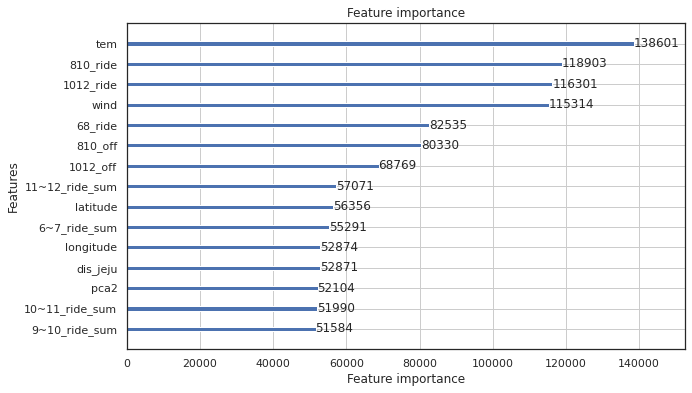

In [436]:
### 1. lgbm
# scongest넣으면 떨어짐. 
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain) # valid를 예측하자

lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.003,
        'num_leaves': 700,
        'max_depth':-1,
        'min_child_weight':5,
        'colsample_bytree': 0.8,
        'subsample':0.7,
        'n_estimators':50000,
        'gamma':0,
#         'reg_lambda':0.05,
#         'reg_alpha':0.05,
        'verbose':-1,
        'seed': 2020,
        'early_stopping_rounds' : 150
    }

model = lgb.train(lgb_params, dtrain, valid_sets=(dtrain, dvalid), valid_names = ('train', 'valid'), 
                   categorical_feature=['weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'dist_name_0', 'dist_name_1', 'dist_name_2', 'dist_name_3'], verbose_eval=100)
val_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

lgb.plot_importance(model, height=0.2, max_num_features = 15, figsize=(10,6))

sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] = test_pred.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/scongest_lgbm.csv", index=False)

# ### 2. random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_features=3,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=500,
                           random_state=1217)

rf.fit(X,y) 
rf_pred = rf.predict(X_test) 
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] = rf_pred.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/scongest_rf.csv", index=False)

# test['18~20_ride'] = rf_pred
# test[['id','18~20_ride']].to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/scongest_rf.csv",index=False) 

### 3. ensemble(가중평균) + xgb까지
# 쓰레기 2.6 lgbm + 2.3 rf = 2.4나옴. 꽤 좋은듯??? 쓰레기모델이어도??
xgb = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/xgboost.csv')
xgb_pred = np.array(xgb['18~20_ride'].tolist())
e_pred = (0.1*xgb_pred + 0.1*test_pred + 0.8*rf_pred) 

sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] = e_pred.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/submission/scongest가중평균+xgb.csv", index=False)